In [1]:
from collections import defaultdict
import json
import os
from string import punctuation

from gensim.summarization import keywords, summarize
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from src.preprocessing import CorpusPreprocess
from src import PROJECT_ROOT


Bad key "text.kerning_factor" on line 4 in
/Users/dafirebanks/miniconda3/envs/dsci/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def get_top_n_ngrams(matrix, vocab, ngram, n=20):
    """
    Function to get top n-grams from from document-term matrix and corresponding vocabulary
    """
    # Filter vocab to include just n-grams
    vocab = dict(filter(lambda x: len(x[0].split()) == ngram, vocab.items()))
    # Filter matrix to include just n-grams
    matrix = matrix[:, list(vocab.values())]
    # Get inverse vocab mapping: new_matrix_index -> n-gram
    inv_vocab = {i: k for i, (k, _) in enumerate(vocab.items())}
    # Get count of each n-gram
    counts = np.asarray(matrix.sum(axis=0)).flatten()
    top_ngrams = defaultdict(int)
    # Iterate over n argmax indexes of counts
    for i in reversed(counts.argsort()[-n:]):
        top_ngrams[inv_vocab[i]] = counts[i]
    return top_ngrams

# Reading the data

In [3]:
# Reading data
INPUT_PATH = os.path.join(PROJECT_ROOT, "tasks", "extract_text", "output")
with open(os.path.join(INPUT_PATH, "pdf_files.json")) as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame(
    {
        "filename": data.keys(),
        "country": [i["Country"] for i in data.values()],
        "text": [i["Text"] for i in data.values()]
    }
)

In [4]:
# Creating word count field
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.count()

filename      62
country       62
text          62
word_count    62
dtype: int64

In [5]:
# Removing document without text
df = df.drop(df.index[df['word_count'] == 1].tolist()).reset_index(drop=True)
df.count()

filename      61
country       61
text          61
word_count    61
dtype: int64

In [6]:
# Removing badly read documents
bad_docs = ["CreditoGanadero_Mexico", "Ley Especial Cafe_ElSalvador", "Sembrando Vida Report"]
df = df.drop(df.index[df['filename'].isin(bad_docs)].tolist()).reset_index(drop=True)
df.count()

filename      58
country       58
text          58
word_count    58
dtype: int64

In [7]:
df.head()

,filename,country,text,word_count
0,2019CVE 1713470_Chile,Chile,CVE 1713470|Director: Juan Jorge Lazo Rodrígue...,10424
1,Decreto 51_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,22478
2,Decreto 95_Chile,Chile,www.bcn.cl - Biblioteca del Congreso Nacional ...,6068
3,Decreto8_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,1209
4,Ley 20412_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,4349


In [8]:
df.count()

filename      58
country       58
text          58
word_count    58
dtype: int64

# Preprocessing the data

#### Experiment: Using a stanza pipeline -> turns out that lemmatization is not as necessary for now

In [9]:
# import stanza 

# nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')
# lemmatize_pipeline = stanza.Pipeline(lang='es', processors='tokenize, lemma')

# def lemmatize_text(text):
#     lemmatized_text = lemmatize_pipeline(text)
#     return " ".join([word.lemma for sentence in lemmatized_text.sentences for word in sentence.words])

# df["pre_pretext"] = df["pre_pretext"].apply(lambda x: lemmatize_text(x))

#### Mix common stopwords with words that we know are frequent, such as dates 

In [10]:
spa_stopwords = set(stopwords.words('spanish'))
extra_stopwords = {"ley", "artículo", "ser", "así", "según", "nº", "diario", 
                   "enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "setiembre", "octubre", "noviembre", "diciembre",
                   "lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo"}
spa_stopwords = spa_stopwords.union(extra_stopwords)

In [11]:
prep = CorpusPreprocess(
    language='spanish', 
    stop_words=spa_stopwords,
    lowercase=True,
    strip_accents=True,
    strip_numbers=True,
    punctuation_list=punctuation,
    strip_urls=True,
#     stemmer=SnowballStemmer('spanish'), 
    max_df=0.9, 
    min_df=2
)

In [12]:
df['prep_text'] = prep.fit_transform(df['text'], tokenize=False)

In [13]:
df.head()

,filename,country,text,word_count,prep_text
0,2019CVE 1713470_Chile,Chile,CVE 1713470|Director: Juan Jorge Lazo Rodrígue...,10424,cve director juan jorge lazo rodriguezsitio we...
1,Decreto 51_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,22478,biblioteca congreso nacional chile documento g...
2,Decreto 95_Chile,Chile,www.bcn.cl - Biblioteca del Congreso Nacional ...,6068,biblioteca congreso nacional chile tipo norma ...
3,Decreto8_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,1209,biblioteca congreso nacional chile documento g...
4,Ley 20412_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,4349,biblioteca congreso nacional chile documento g...


# Word count for each document

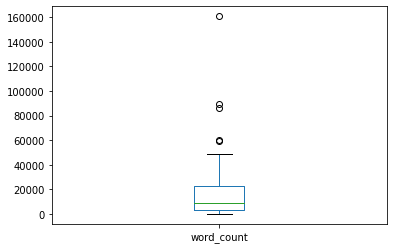

In [14]:
# Fetch word count for each document
df['word_count'].plot(kind='box')
plt.show()

In [15]:
# Describe word count
df['word_count'].describe()

count        58.000000
mean      17938.793103
std       27200.201866
min           3.000000
25%        3149.750000
50%        8626.500000
75%       22386.500000
max      160786.000000
Name: word_count, dtype: float64

Should we weight each document? Otherwise we could find keywords that do not represent each document in the same way.

# Bag-of-Words

In [16]:
# Count Vectorizer
cv = CountVectorizer(max_features=20000, ngram_range=(1,7))
bow_X = cv.fit_transform(df['prep_text'])

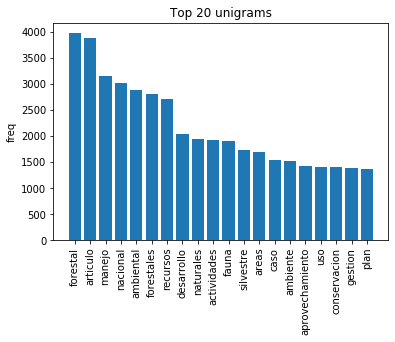

In [17]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

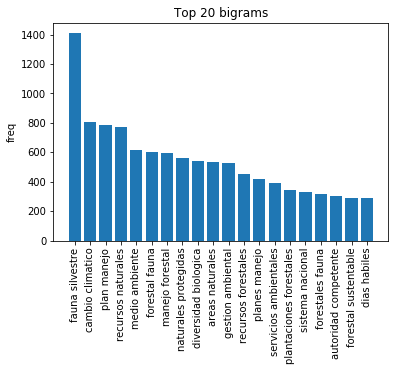

In [18]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

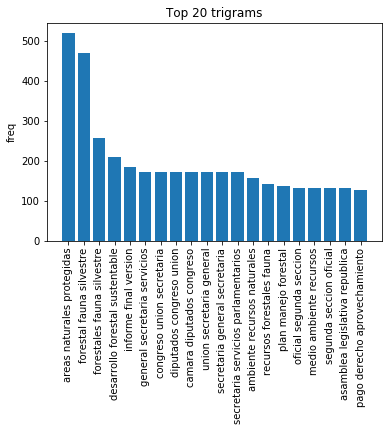

In [19]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

In [20]:
top_trigrams

defaultdict(int,
            {'areas naturales protegidas': 518,
             'forestal fauna silvestre': 469,
             'forestales fauna silvestre': 257,
             'desarrollo forestal sustentable': 208,
             'informe final version': 183,
             'general secretaria servicios': 171,
             'congreso union secretaria': 171,
             'diputados congreso union': 171,
             'camara diputados congreso': 171,
             'union secretaria general': 171,
             'secretaria general secretaria': 171,
             'secretaria servicios parlamentarios': 171,
             'ambiente recursos naturales': 156,
             'recursos forestales fauna': 142,
             'plan manejo forestal': 137,
             'oficial segunda seccion': 131,
             'medio ambiente recursos': 131,
             'segunda seccion oficial': 131,
             'asamblea legislativa republica': 131,
             'pago derecho aprovechamiento': 127})

## What if we want to normalize by word counts?

In [21]:
bow_X_norm = bow_X / bow_X.sum(axis=1)

/Users/dafirebanks/miniconda3/envs/dsci/lib/python3.7/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


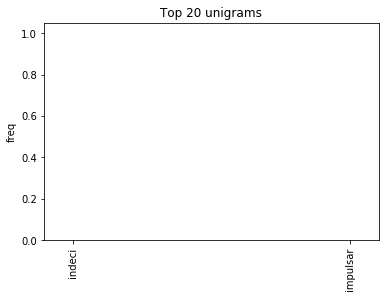

In [22]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

In [ ]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

In [ ]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

In [ ]:
top_trigrams

# TF-IDF

In [ ]:
# Count Vectorizer
tv = TfidfVectorizer(max_features=20000, ngram_range=(1,3))
tfidf_X = tv.fit_transform(df['prep_text'])

In [ ]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(tfidf_X, tv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

In [ ]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(tfidf_X, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

In [ ]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(tfidf_X, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

# Can we see keywords for single document?

In [ ]:
print(df.loc[40, "text"][:1000],"...")

print('\nGet top uni-grams bow:')
for k, v in get_top_n_ngrams(bow_X[40], cv.vocabulary_, 1, 10).items():
    print(f"\"{k}\" count: {round(v,3)}")
    
print('\nGet top uni-grams tfidf:')
for k, v in get_top_n_ngrams(tfidf_X[40], tv.vocabulary_, 1, 10).items():
    print(f"\"{k}\" count: {round(v,3)}")

# Word cloud

## BOW

In [ ]:
sorted_vocab = {k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(bow_X.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

## BOW normalized

In [ ]:
sorted_vocab = {k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(bow_X_norm.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

## TF-IDF

In [ ]:
sorted_vocab = {k: v for k, v in sorted(tv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(tfidf_X.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

# Keyword extraction algorithms

## Preprocessing (keep sentence structure)

In [ ]:
sentences = df['text'].apply(lambda x: sent_tokenize(x, language='spanish')).explode()
sentences

In [ ]:
# Word count per sentence
sentences.str.split().apply(lambda x: len(x)).describe()

In [ ]:
prep = CorpusPreprocess(
    language='spanish', 
    stop_words=spa_stopwords,
    lowercase=True,
    strip_accents=True,
    strip_numbers=True,
    strip_punctuation=punctuation,
#   stemmer=SnowballStemmer('spanish'), 
    max_df=0.9, 
    min_df=2
)

sentences_prep = pd.Series(prep.fit_transform(sentences, tokenize=False), index=sentences.index)

In [ ]:
sentences_prep

# Rake and TextRank

In [ ]:
for ix in sentences_prep.index.unique():
    # RAKE
    rake = Rake(language="spanish")
    rake.extract_keywords_from_sentences(sentences_prep[ix])
    rake_out = rake.get_ranked_phrases()
    print("\nRAKE OUTPUT:\n> ", "\n> ".join(rake_out[:10]))
    
    # TextRankV1
    textrankv1_out = keywords(" ".join(sentences_prep[ix]), split=True)
    print("\nTEXTRANKV1 OUTPUT:\n> ", "\n> ".join(textrankv1_out[:10]))
    
    # TextRankV2
    textrankv2_out = summarize(". ".join(sentences_prep[ix]), split=True)
    print("\nTEXTRANKV2 OUTPUT:\n> ", "\n> ".join(textrankv2_out[:10]))
    break

# Look into 
https://boudinfl.github.io/pke/build/html/index.html